# Lab4a - Working with NASA PACE data in HyperCoast

This notebook demonstrates how to visualize and analyze Plankton, Aerosol, Cloud, ocean Ecosystem ([PACE](https://pace.gsfc.nasa.gov/)) data interactively with HyperCoast.

## Environment setup

Uncomment and run the following cell to install the required packages.

In [8]:
%pip install "hypercoast[extra]"
# %pip install -U localtileserver

Note: you may need to restart the kernel to use updated packages.


Import libraries.

In [2]:
import earthaccess
import hypercoast
import pandas as pd

c:\Users\C00553090\AppData\Local\miniconda3\envs\hypercoast\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Search for PACE data

To download and access the data, you will need to create an Earthdata login. You can register for an account at [urs.earthdata.nasa.gov](https://urs.earthdata.nasa.gov). Once you have an account, run the following cell and enter your NASA Earthdata login credentials.

In [ ]:
earthaccess.login(persist=True)

### Search data programmatically

To search for PACE data programmatically, specify the bounding box and time range of interest. Set `count=-1` to return all results or set `count=10` to return the first 10 results.

In [11]:
results, gdf = hypercoast.search_pace(
    bounding_box=(-90, 25, -88, 28),
    temporal=("2024-10-10", "2024-10-10"),
    short_name="PACE_OCI_L2_AOP_NRT",
    count=10,
    return_gdf=True,
)

Plot the footprints of the returned datasets on a map.

In [ ]:
gdf.explore()

Download the first dataset from the search results. Note that the download may take some time.

In [ ]:
hypercoast.download_pace(results[:1], out_dir="data")

### Search data interactively

To search for PACE data interactively, pan and zoom to the area of interest. Specify the time range of interest from the search dialog, then click on the Search button.

In [ ]:
m = hypercoast.Map(center=[30.0262, -90.1345], zoom=8)
m.search_pace(default_dataset="PACE_OCI_L2_AOP_NRT")
m

By default, the `search_pace` method searches for the `PACE_OCI_L2_AOP_NRT` dataset, but you can specify the dataset name by setting the `default_dataset` parameter, such as `PACE_OCI_L2_BGC_NRT`. For more information about the available datasets, see the [PACE Data Products](https://pace.oceansciences.org/data_table.htm) page.

![image](https://github.com/user-attachments/assets/2c45ad43-c405-402a-92e8-42f497730fbb)

Uncomment the following cell to display the GeoDataFrame of the search results.

In [ ]:
# m._NASA_DATA_GDF.head()

Similarly, you can download the first dataset from the search results by uncommenting the following cell.

In [ ]:
# hypercoast.download_pace(results[:1], out_dir="data")

## Read PACE data


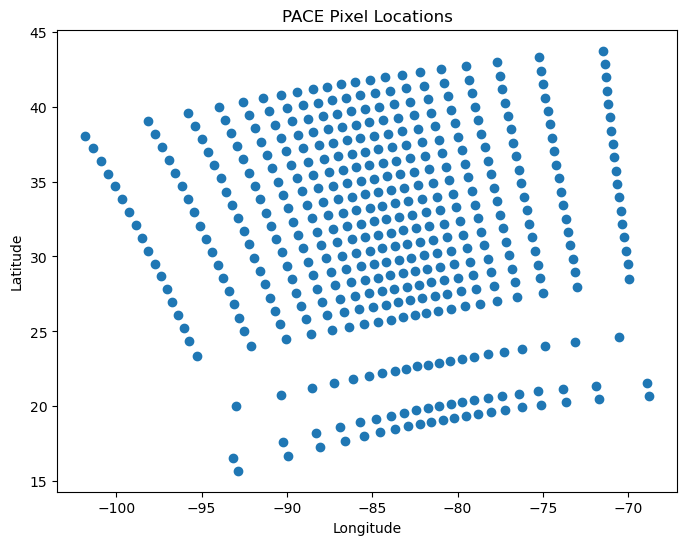

In [5]:
filepath = "PACE_OCI.20240730T181157.L2.OC_AOP.V2_0.NRT.nc"
plot = hypercoast.view_pace_pixel_locations(filepath, step=20)

Load the dataset as a `xarray.Dataset` object.

In [6]:
dataset = hypercoast.read_pace(filepath)
# dataset

## Visualize PACE AOP data

Visualize selected bands of the dataset.

In [ ]:
hypercoast.viz_pace(dataset, wavelengths=[500, 510, 520, 530], ncols=2)

Add custom projection and administrative boundaries to the map. The default projection is `PlateCarree`. You can specify a custom projection by setting the `crs` parameter. For more information about the available projections, see the [cartopy projection](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) page.

In [ ]:
hypercoast.viz_pace(dataset, wavelengths=[500, 510, 520, 530], ncols=2, crs="default")

## Plot spectral signatures

Plot the spectral signature of a pixel using the `extract_pace` function. Set `return_plot=True` to return the plot object. 

In [ ]:
latitude = 29.9307
longitude = -87.9106
hypercoast.extract_pace(dataset, latitude, longitude, return_plot=True)

## Interactive visualization

### Single-band visualization

Visualize a selected band of the dataset interactively use the `add_pace` method and speccify the `wavelengths` parameter.

In [ ]:
m = hypercoast.Map()
m.add_basemap("Hybrid")
wavelengths = [450]
m.add_pace(dataset, wavelengths, colormap="jet", vmin=0, vmax=0.02, layer_name="PACE")
m.add_colormap(cmap="jet", vmin=0, vmax=0.02, label="Reflectance")
m.add("spectral")
m.set_center(-80.7382, 26.5295, zoom=6)
m

### Multi-band visualization

Select three spectral bands to visualize as an RGB image.

In [ ]:
m = hypercoast.Map()
m.add_basemap("Hybrid")
wavelengths = [450, 550, 650]
m.add_pace(
    dataset, wavelengths, indexes=[3, 2, 1], vmin=0, vmax=0.02, layer_name="PACE"
)
m.add("spectral")
m.set_center(-80.7382, 26.5295, zoom=6)
m

## PACE BGC data

PACE has a variety of data products, including biogeochemical properties. For more information about the available datasets, see the [PACE Data Products](https://pace.oceansciences.org/data_table.htm) page.

The PACE Biogeochemical (BGC) data products include chlorophyll-a concentration, particulate organic carbon, and particulate inorganic carbon.

### Download PACE BGC data

Let's download a sample PACE BGC dataset for the demonstration.

In [ ]:
results, gdf = hypercoast.search_nasa_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    bbox=(-90.5642, 29.9749, -89.7143, 30.42),
    temporal=("2024-10-10", "2024-10-10"),
    count=1,
    return_gdf=True,
)
hypercoast.download_nasa_data(results, out_dir="data")

Load the downloaded dataset as an `xarray.Dataset`:

In [23]:
filepath = "data/PACE_OCI.20241010T183444.L2.OC_BGC.V2_0.NRT.nc"
dataset = hypercoast.read_pace_bgc(filepath)

Let's inspect the data variables contained in the dataset:

In [ ]:
dataset.variables

We can see that the dataset contains the following variables:
- [Chlorophyll Concentration](https://www.earthdata.nasa.gov/apt/documents/chlor-a/v1.0)
- [Phytoplankton Carbon](https://oceancolor.gsfc.nasa.gov/resources/atbd/cphyt/)
- [Particulate Organic Carbon](https://oceancolor.gsfc.nasa.gov/resources/atbd/poc/)

### Visualize PACE BGC data

Since the datasets are not gridded, we need to transform them into gridded data to visualize them. We can use the `grid_pace_bgc` function to transform the dataset into a gridded format.

First, transform the `chlor_a` variable into a gridded format:

In [25]:
chlor_a = hypercoast.grid_pace_bgc(dataset, variable="chlor_a", method="linear")

Plot the gridded Chlorophyll Concentration data:

In [ ]:
chlor_a.plot(vmin=0, vmax=20, cmap="jet", size=6)

Plot the gridded Phytoplankton Carbon data:

In [ ]:
carbon_phyto = hypercoast.grid_pace_bgc(
    dataset, variable="carbon_phyto", method="linear"
)
carbon_phyto.plot(vmin=0, vmax=120, cmap="jet", size=6)

Plot the gridded Particulate Organic Carbon data:

In [ ]:
poc = hypercoast.grid_pace_bgc(dataset, variable="poc", method="linear")
poc.plot(vmin=0, vmax=1000, cmap="jet")

Plot the gridded BGC data on an interactive map.

In [ ]:
m = hypercoast.Map()
m.add_basemap("Hybrid")
m.add_raster(chlor_a, layer_name="Chlorophyll-a", colormap="jet", vmin=0, vmax=20)
m.add_raster(
    carbon_phyto, layer_name="Phytoplankton Carbon", colormap="plasma", vmin=0, vmax=120
)
m.add_raster(
    poc, layer_name="Particulate Organic Carbon", colormap="coolwarm", vmin=0, vmax=1000
)
m.add_layer_manager()

m.add_colormap(cmap="jet", vmin=0, vmax=20, label="Chlorophyll-a (mg/m3)")
m.add_colormap(cmap="plasma", vmin=0, vmax=120, label="Phytoplankton Carbon (mg/m3)")
m.add_colormap(
    cmap="coolwarm", vmin=0, vmax=1000, label="Particulate Organic Carbon (mg/m3)"
)
m.set_center(-80.7382, 26.5295, zoom=6)
m

![](https://i.imgur.com/AEccc5k.gif)